## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Семенников Макар Алексеевич

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 октября.


### Часть 1: Инициализация весов

Зафиксируем seed

In [2]:
import torch
import random
import os

def seed_everything(seed: int):
    # Для генератора случайных чисел Python
    random.seed(seed)
    
    # Для numpy
    np.random.seed(seed)
    
    # Для torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    
    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(44)

Будем использовать MNIST для обучения:

In [3]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [4]:
images_train, labels_train = next(iter(train_loader))

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

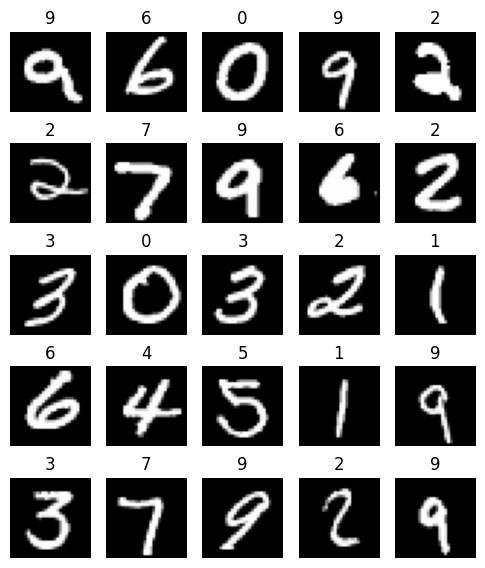

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [16]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2 / (28*28))
init_layer(layer_2, 0, 2 / 500)

Соберем все вместе, используя ReLU в качестве функции активации:

In [17]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

In [18]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0189528465270996
forward 0.042161229997873306
backward 0.021602468565106392
backward 0.0007209531031548977


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

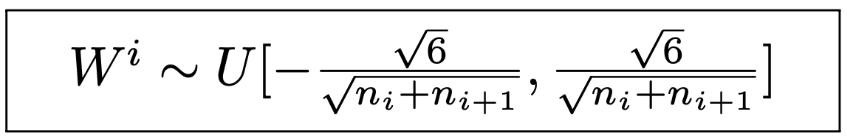

In [19]:
# Функция, вычисляющая параметры равномерного распределения
def uniform_param(in_n, out_n):
    value = np.sqrt(6)/np.sqrt(in_n + out_n)
    return -value, value

In [20]:
def init_layer_Xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(*uniform_param(layer.in_features, layer.out_features))

In [21]:
layer_x_1 = nn.Linear(28*28, 500)
layer_x_2 = nn.Linear(500, 10)

layer_x_1.register_forward_hook(forward_hook)
layer_x_2.register_forward_hook(forward_hook)

layer_x_1.register_backward_hook(backward_hook)
layer_x_2.register_backward_hook(backward_hook)

init_layer_Xavier(layer_x_1)
init_layer_Xavier(layer_x_2)

In [22]:
network_2 = nn.Sequential(
    layer_x_1,
    nn.Tanh(),
    layer_x_2
)

In [23]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network_2(X)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(network_2.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0189528465270996
forward 0.6541188955307007
backward 0.021602468565106392
backward 0.012540026567876339


#### Выводы:
Как можно заметить, "Xavier" инициализация также приводит дисперсию слоев к некоторому единообразному значению, однако она всё же выше, чем при "He" инициализации, и не так быстро убывает в процессе backward.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

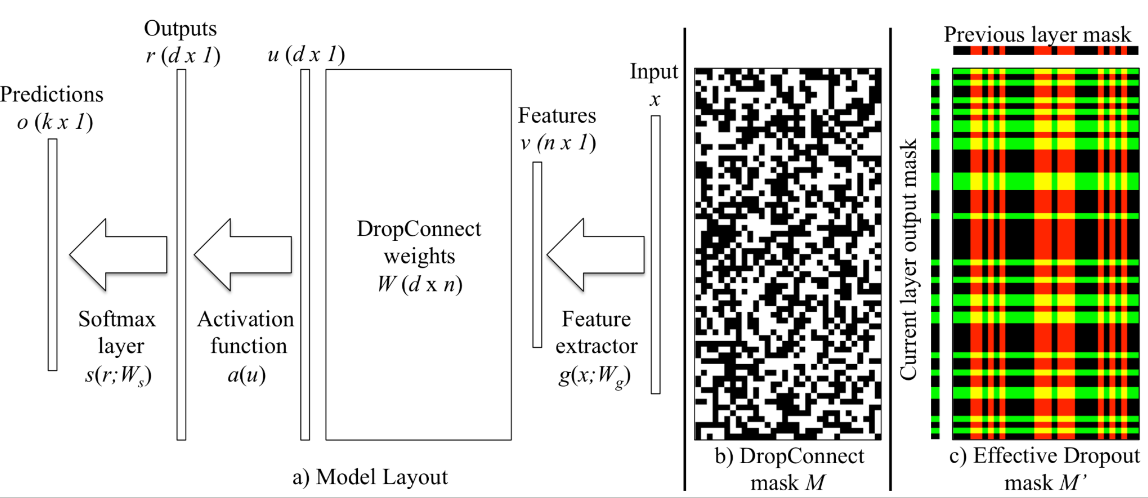

In [24]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.bernoulli(torch.full_like(self.linear.weight, 1 - self.p))
            mask = torch.autograd.Variable(mask, requires_grad=False)
        else:
            ## Предполагается, что во время использования градиенты и так отключены
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [25]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [26]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128, 0.2),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(128, 128, 0.2),
    nn.Linear(128, 10),
]

In [27]:
network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [28]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.308045
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.608600
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.420716
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.202935
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.253555
Test Epoch: 0	Loss: 0.178935
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.172508
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.088029
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.136217
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.121971
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.128026
Test Epoch: 1	Loss: 0.120244
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.124850
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.151514
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.074966
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.115441
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.188911
Test Epoch: 2	Loss: 0.116343
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.044814
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.037233
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.065778
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Снова подтяну функцию обучения из прошлых ДЗ (Уж очень она мне нравится)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Current device is {device}')

Current device is cuda


In [30]:
from IPython.core.display_functions import clear_output
import sys
from torch.nn import NLLLoss


def train_custom(model, train_loader, val_loader, epochs, optimizer, plot=True,
          verbose=True, criterion=None):
    
    criterion = criterion or NLLLoss()
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    try:
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
    
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
    
                optimizer.zero_grad()  # Обнуляем градиенты
    
                # Прямой проход
                outputs = model(inputs)
                loss = criterion(outputs, labels)
    
                # Обратный проход
                loss.backward()
                optimizer.step()
    
                # Накопление статистики
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)
    
            # Вычисляем средние значения по эпохе
            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train
    
            # Сохраняем значения в массивы
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)
    
            # Валидация
            model.eval()  # Устанавливаем режим валидации
            running_val_loss = 0.0
            correct_val = 0
            total_val = 0
    
            with torch.no_grad():  # Отключаем градиенты для валидации
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
    
                    running_val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
    
            # Вычисляем средние значения по валидации
            val_loss = running_val_loss / len(val_loader)
            val_accuracy = 100 * correct_val / total_val
    
            # Сохраняем значения в массивы
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_losses[-1], val_losses[-1],
                            train_accuracies[-1], val_accuracies[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                # plt.title(f'Model with {optimizer_name} optimizer.')
                plt.subplot(1, 2, 1)
                plt.plot(train_losses, label='Train')
                plt.plot(val_losses, label='Val')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracies, label='Train accuracy')
                plt.plot(val_accuracies, label='Val accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_losses, \
           val_losses, \
           train_accuracies, \
           val_accuracies

Также возьму класс Dropout с семинара для сравнения

In [37]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        device = x.device
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor).to(device)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

Создаём 2 нейросети и строим для них графики

In [40]:
layers_Do = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10),
]

layers_Dc = [
    nn.Linear(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.Linear(128, 10),
]
net_Do = TestNetwork(nn.Sequential(*layers_Do))
optimizer_Do = torch.optim.Adam(net_Do.parameters(), lr=0.001)
net_Do.to(device)

net_Dc = TestNetwork(nn.Sequential(*layers_Dc))
optimizer_Dc = torch.optim.Adam(net_Dc.parameters(), lr=0.001)
_ = net_Dc.to(device)

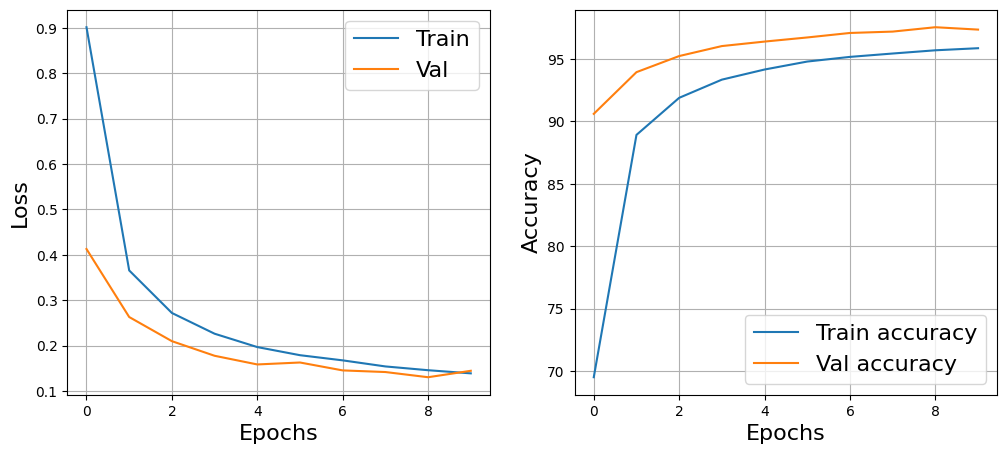

In [41]:
train_losses_Do, val_losses_Do, train_accuracies_Do, val_accuracies_Do = train_custom(net_Do, train_loader, test_loader, epochs=10, optimizer=optimizer_Do)

In [43]:
val_accuracies_Do[-1]

97.36

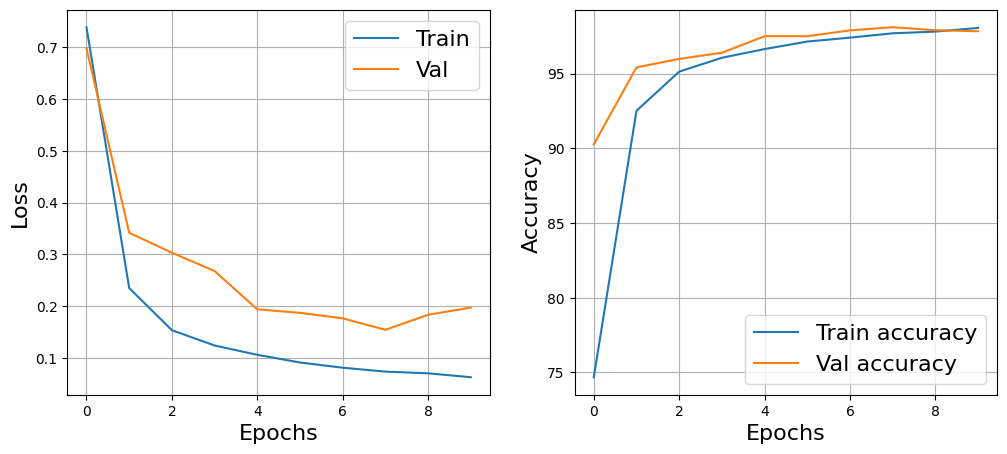

In [42]:
train_losses_Dc, val_losses_Dc, train_accuracies_Dc, val_accuracies_Dc = train_custom(net_Dc, train_loader, test_loader, epochs=10, optimizer=optimizer_Dc)

In [44]:
val_accuracies_Dc[-1]

97.84

Видно, что при использовании DropConnections качество обучения лучше, однако переобучение наступает быстрее и loss менее гладко.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

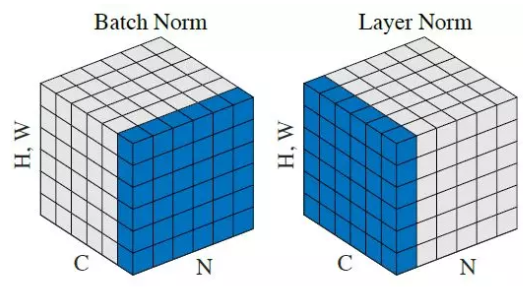

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [68]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        output = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-5)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

Опять реализуем 2 нейросети

In [69]:
layers_Bn = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10),
]

layers_Ln = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10),
]
net_Bn = TestNetwork(nn.Sequential(*layers_Bn))
optimizer_Bn = torch.optim.Adam(net_Bn.parameters(), lr=0.001)
net_Bn.to(device)

net_Ln = TestNetwork(nn.Sequential(*layers_Ln))
optimizer_Ln = torch.optim.Adam(net_Ln.parameters(), lr=0.001)
_ = net_Ln.to(device)

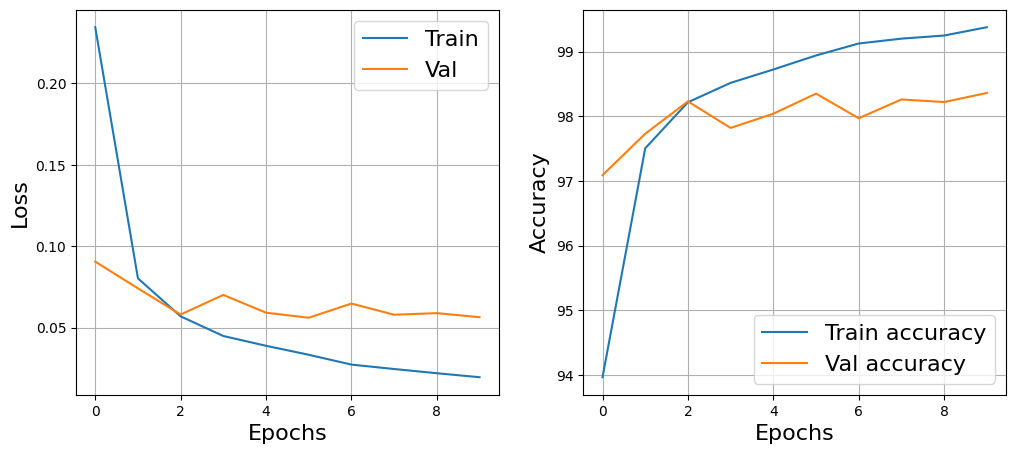

In [48]:
train_losses_Bn, val_losses_Bn, train_accuracies_Bn, val_accuracies_Bn = train_custom(net_Bn, train_loader, test_loader, epochs=10, optimizer=optimizer_Bn)

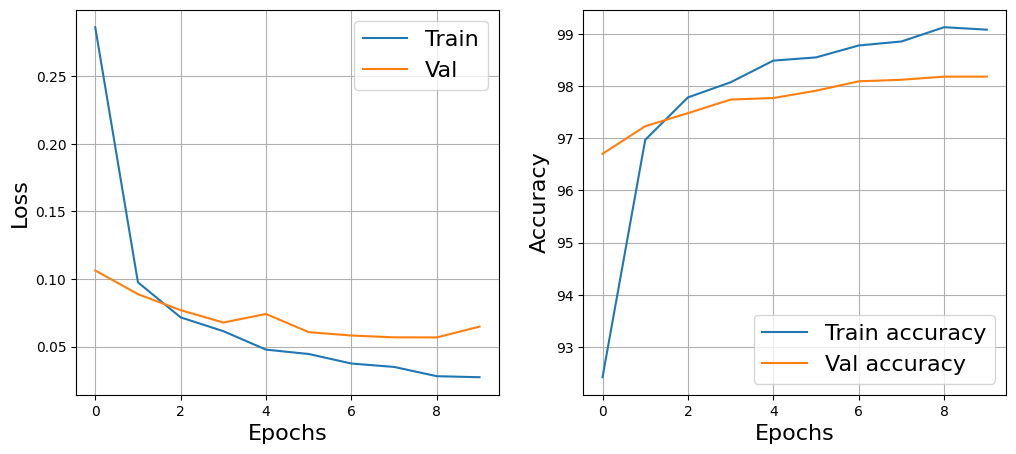

In [70]:
train_losses_Ln, val_losses_Ln, train_accuracies_Ln, val_accuracies_Ln = train_custom(net_Ln, train_loader, test_loader, epochs=10, optimizer=optimizer_Ln)

Можно заметить то, что с BatchNorm переобучение наступает чуть быстрее, и в принципе качество обучения лучше, но с LayerNorm получается более монотонное убывание loss-а.